In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf 
import talib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [95]:
warnings.filterwarnings("ignore")
data = yf.download("SEPC.NS", start="2016-01-01", end="2025-01-30")
print(data.head)
print(data.shape)
data.sort_index(inplace=True)
print(data[-10:])

[*********************100%***********************]  1 of 1 completed

<bound method NDFrame.head of Price           Close       High        Low       Open   Volume
Ticker        SEPC.NS    SEPC.NS    SEPC.NS    SEPC.NS  SEPC.NS
Date                                                           
2016-01-01  34.862625  35.405045  33.531239  34.024345    24964
2016-01-04  35.158489  35.750217  34.073658  34.073658    61054
2016-01-05  34.862625  35.454353  34.320210  35.405045   137078
2016-01-06  35.848839  37.821266  34.616074  35.010559   943607
2016-01-07  33.580551  36.095394  33.087444  35.848839    94016
...               ...        ...        ...        ...      ...
2025-01-23  18.150000  18.450001  17.959999  18.360001  3881715
2025-01-24  17.360001  18.250000  17.299999  18.139999  6387581
2025-01-27  16.600000  17.190001  16.389999  17.190001  6809231
2025-01-28  16.290001  16.860001  15.710000  16.639999  6802898
2025-01-29  16.940001  17.100000  16.400000  16.400000  6246382

[2242 rows x 5 columns]>
(2242, 5)
Price           Close       High      

In [91]:
data['LogVolume']=np.log(data['Volume'].replace(0,np.nan))
data.drop(columns='Volume', inplace=True)
data.dropna(axis=0, how='all')


Price,Close,High,Low,Open,LogVolume
Ticker,SEPC.NS,SEPC.NS,SEPC.NS,SEPC.NS,
Date,,,,,
2016-01-01,34.862625,35.405045,33.531239,34.024345,10.125190
2016-01-04,35.158489,35.750217,34.073658,34.073658,11.019514
2016-01-05,34.862625,35.454353,34.320210,35.405045,11.828305
2016-01-06,35.848839,37.821266,34.616074,35.010559,13.757465
2016-01-07,33.580551,36.095394,33.087444,35.848839,11.451220
...,...,...,...,...,...
2025-01-23,18.150000,18.450001,17.959999,18.360001,15.171788
2025-01-24,17.360001,18.250000,17.299999,18.139999,15.669866


In [92]:
# Check for NaN values in LogVolume and get the indices
nan_indices = data[data['LogVolume'].isnull()].index

# Drop the rows where LogVolume is NaN
data = data.drop(nan_indices)

# Optionally, you can reset the index after dropping the rows if needed
data = data.reset_index(drop=True)
data.isnull().sum()

Price      Ticker 
Close      SEPC.NS    0
High       SEPC.NS    0
Low        SEPC.NS    0
Open       SEPC.NS    0
LogVolume             0
dtype: int64

In [93]:
scaler=MinMaxScaler()
scaled_values=scaler.fit_transform(data[data.columns])
df=pd.DataFrame(scaled_values, columns=data.columns, index=data.index)
df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, SEPC.NS)  2240 non-null   float64
 1   (High, SEPC.NS)   2240 non-null   float64
 2   (Low, SEPC.NS)    2240 non-null   float64
 3   (Open, SEPC.NS)   2240 non-null   float64
 4   (LogVolume, )     2240 non-null   float64
dtypes: float64(5)
memory usage: 87.6 KB
None


(442, 30, 5)
Error in callback <function _draw_all_if_interactive at 0x0000026253ED23E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

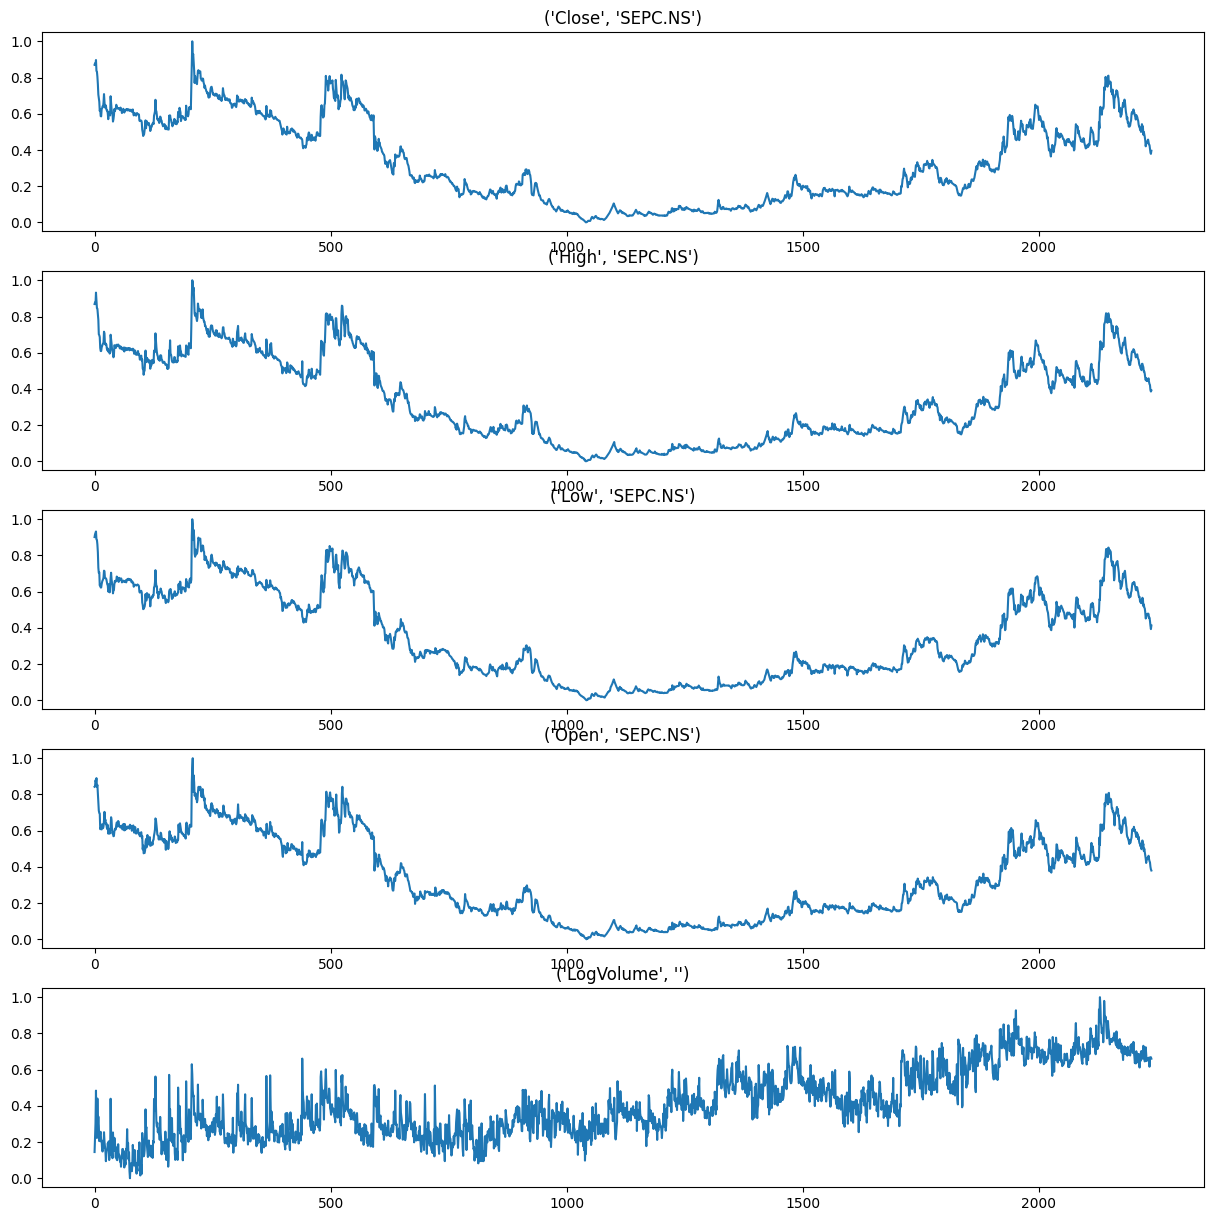

In [94]:

#plotting
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(5)

for ax, col in zip(axes, df.columns):
  ax.plot(df[col])
  ax.set_title(col)

window_size=30

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)


X, y = create_sequence(df, window_size)

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=20)

print(X_test.shape)

LSTM:

In [ ]:
model = keras.Sequential([
    #1st lstm layer
    keras.layers.LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.3),

    #2nd lstm layer
    keras.layers.LSTM(units = 50, return_sequences=True),
    keras.layers.Dropout(0.3),

    #3rd lstm layer
    keras.layers.LSTM(units = 50, return_sequences=False),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(y_train.shape[1])
])

optimizer= Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=5,
                    batch_size=3,
                    callbacks=[early_stopping])

predictions=model.predict(X_test)

y_test_rescaling= scaler.inverse_transform(y_test)
predictions_rescaling= scaler.inverse_transform(predictions)

#PLOTTING
# plt.figure(figsize=(15,5))

# for i, col in enumerate(df.columns):
#     plt.subplot(2, 3, i + 1)
#     plt.plot(y_test_rescaling[:, i], color='blue', label=f'Actual {col}')
#     plt.plot(predictions_rescaling[:, i], color='red', label=f'Predicted {col}')
#     plt.title(f'{col} Price Prediction')
#     plt.xlabel('Time')
#     plt.ylabel(f'{col} Price')
#     plt.legend()

# plt.tight_layout()

Epoch 1/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.1083 - mae: 0.1083 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 2/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0609 - mae: 0.0609 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 3/5
417/472 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0567 - mae: 0.0567

KeyboardInterrupt: 

predicting post january

In [81]:
future_predictions = []

for _ in range(10):  # predict 10 days into the future
    prediction = model.predict(current_input)
    future_predictions.append(prediction)
    
    # Use the latest prediction as the new input
    current_input = np.append(current_input[:,1:,:], prediction.reshape(1, 1, -1), axis=1)

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, y_train.shape[1]))

print("Future Stock Prices:")
print(future_predictions_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Future Stock Prices:
[[14.352315 14.987936 13.912445 14.018714 14.270054]
 [14.259439 14.900251 13.829522 13.935841 14.215553]
 [14.204951 14.85709  13.785549 13.893898 14.176953]
 [14.177343 14.844382 13.76806  13.879553 14.151227]
 [14.165808 14.848757 13.765505 13.880514 14.134509]
 [14.162931 14.860952 13.770079 13.888481 14.123464]
 [14.164412 14.875654 13.77742  13.898809 14.115677]
 [14.168038 14.890298 13.785467 13.909336 14.109583]
 [14.172785 14.903922 13.79345  13.919285 14.104268]
 [14.178196 14.916355 13.801194 13.928548 14.09925 ]]
